# Example of usage Spark OCR for Tables Recognition

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/tab_images/*.jpg"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.3.0.spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [2]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [3]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.1")

spark

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.3.0



## Read images and display it


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


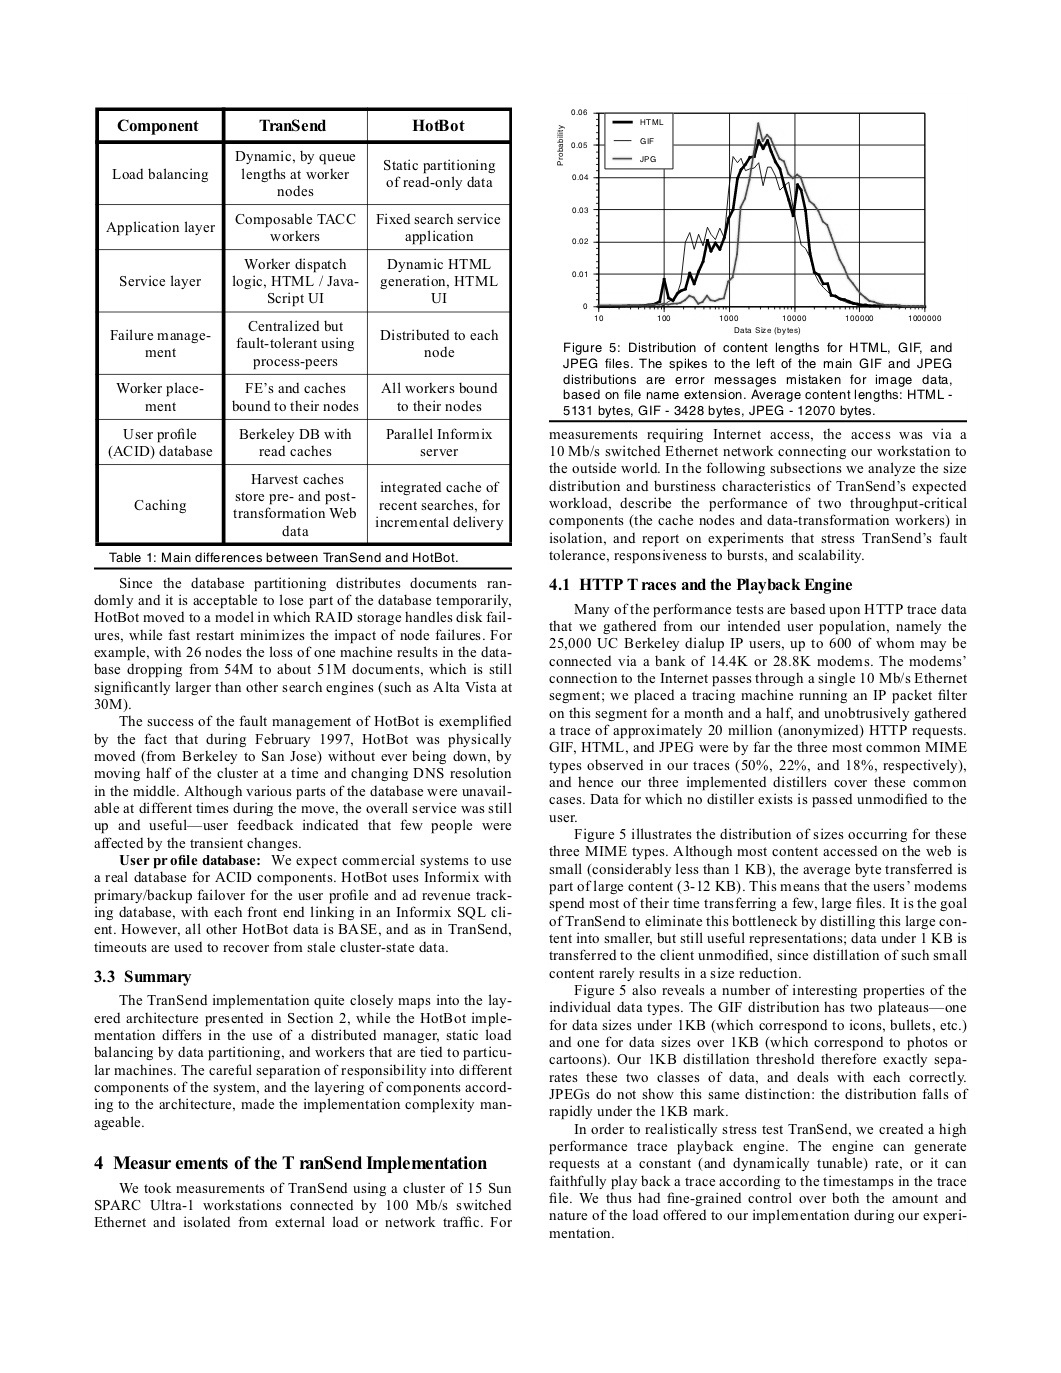


    Image #1:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


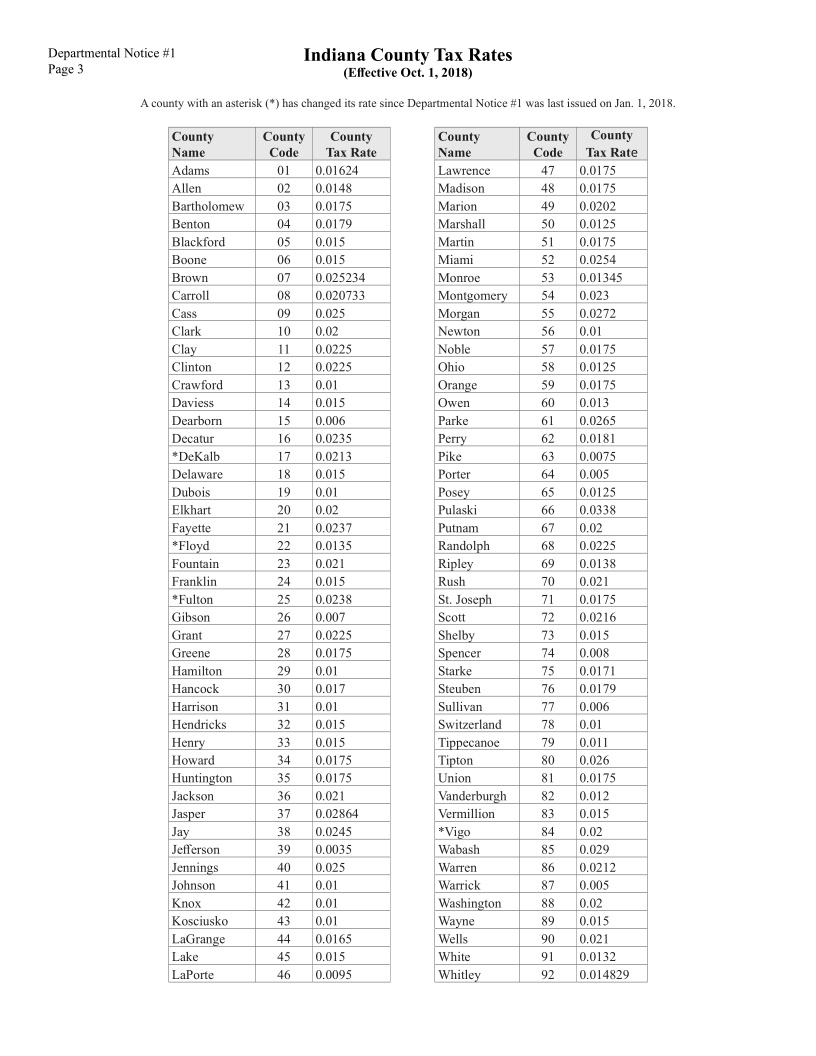

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images
from pyspark.ml import PipelineModel
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import pyspark.sql.functions as f


image_df= spark.read.format("binaryFile").load(imagePath)

# add index to the dataframe
image_df_with_seq_id = image_df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [6]:
binary_to_image = BinaryToImage()
# need set image type for correct work TableDetection model
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(10)

scaler = ImageScaler()
scaler.setInputCol("table_image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2)

cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("scaled_image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("scaled_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(1)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')


pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    scaler,
    cell_detector,
    table_recognition
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


## Run pipeline and show images with tables


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 419 px
    Height: 443 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


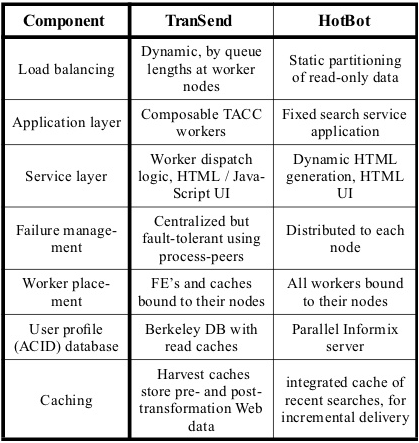


    Image #1:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 222 px
    Height: 872 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


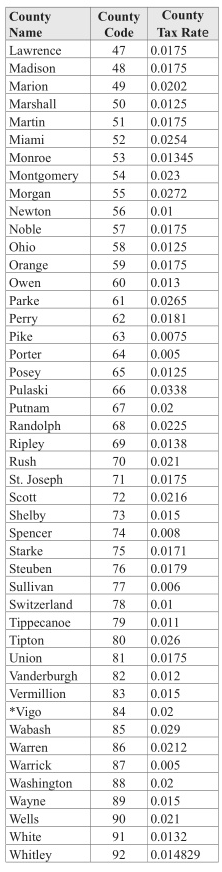


    Image #2:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 229 px
    Height: 859 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


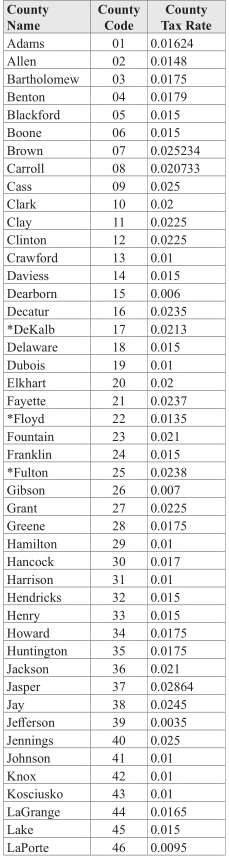

In [7]:
results = pipeline.transform(image_df_with_seq_id).cache()
display_images(results, "table_image")

## Show table content for first file

In [8]:
path_array = f.split(results['path'], '/')

exploded_results = results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .select("index", "table", "region","filename") \
    .withColumn("cells", f.explode(f.col("table.chunks"))) \
    .select([f.col("filename"), f.col("region.index").alias("table")] + [f.col("cells")[i].getField("chunkText").alias(f"col{i}") for i in
             range(0, 3)]) \

exploded_results.filter(f.col("index") == 0).show(10, False)

+----------------+-----+------------------------------------------------+--------------------------------------------------------+-----------------------------------------------------------+
|filename        |table|col0                                            |col1                                                    |col2                                                       |
+----------------+-----+------------------------------------------------+--------------------------------------------------------+-----------------------------------------------------------+
|cTDaR_t10168.jpg|0    |Component                                       || TranSend                                              |HotBot                                                     |
|cTDaR_t10168.jpg|0    |Load balancing                                  |Dynamic, by queuelengths at workernodes                 |Static partitioningof read-only data                       |
|cTDaR_t10168.jpg|0    |Application layer    

## Show table content for second file

In [9]:
exploded_results.filter(f.col("index") == 1).show(100, False)

+----------------+-----+-----------+----------+--------------+
|filename        |table|col0       |col1      |col2          |
+----------------+-----+-----------+----------+--------------+
|cTDaR_t10011.jpg|0    |CountyName |CountyCode|CountyTax Rate|
|cTDaR_t10011.jpg|0    |Lawrence   |47        |0.0175        |
|cTDaR_t10011.jpg|0    |Madison    |48        |0.0175        |
|cTDaR_t10011.jpg|0    |Marion     |49        |0.0202        |
|cTDaR_t10011.jpg|0    |Marshall   |50        |0.0125        |
|cTDaR_t10011.jpg|0    |Martin     |S51       |0.0175        |
|cTDaR_t10011.jpg|0    |Miami      |52        |0.0254        |
|cTDaR_t10011.jpg|0    |Monroe     |53        |0.01345       |
|cTDaR_t10011.jpg|0    |Montgomery |54        |0.023         |
|cTDaR_t10011.jpg|0    |Morgan     |55        |0.0272        |
|cTDaR_t10011.jpg|0    |Newton     |56        |0.01          |
|cTDaR_t10011.jpg|0    |Noble      |57        |0.0175        |
|cTDaR_t10011.jpg|0    |Ohio       |58        |0.0125  